In [14]:
import numpy as np
import nibabel as nib
import pytorch_lightning as pl
import os
import torch
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from monai.inferers import SimpleInferer

sys.path.append('models/')
from models import *

gpusToUse = [7]

In [15]:
# UTILS
def prediction_and_plot_feature_maps(subj, model_loaded, task_labels='LVO-affected hemisphere (0: right; 1: left)', title='Subject X'):

    input_model = (torch.unsqueeze(torch.tensor(np.ascontiguousarray(subj), dtype=torch.float32),0)).to('cuda:'+str(gpusToUse[0])+'')

    while len(input_model.shape) < 6:
        input_model = torch.unsqueeze(input_model,0)
        
    model_loaded.eval()
    with torch.no_grad():
        inferer = SimpleInferer()
        prediction, feature_map_2d = inferer(inputs=input_model, network=model_loaded) # Self calls the forward method of the model

    prediction = np.round(prediction[0].detach().cpu().numpy(), decimals=4)
    pred = str(np.float32(prediction))
    print('\n \n Prediction : ',task_labels,'  ',pred)

    feature_map_2d = feature_map_2d[0].detach().cpu().numpy()

    num_rows = 4
    num_cols = 8
    fig_size = (14, 10)

    # Plot the feature outputs in a grid of plots
    num_plots = len(feature_map_2d)

    fig, axes = plt.subplots(num_rows, num_cols, figsize = fig_size)
    fig.tight_layout()
    plt.suptitle(title + '\n')

    for i, features in enumerate(feature_map_2d):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].imshow(np.rot90(features),'CMRmap')
        # axes[row, col].set_title(f"Feature map  {i+1}")
        axes[row,col].axis('off')
        axes[row,col].set_title(f"id={i}")

    plt.show()

## LVO-affected hemisphere classification

In [16]:
model = L3P_2D_CNN_sagittal()
model_ckpt = 'models/pretrained weights/LVO-hemisphere-L3P_2D_CNN_sagittal.ckpt'
model_loaded = classificationModel.load_from_checkpoint(checkpoint_path=model_ckpt, number_classes=1, model=model, map_location='cuda:'+str(gpusToUse[0])+'')


 
 Prediction :  LVO-affected hemisphere (0: right; 1: left)    0.9957


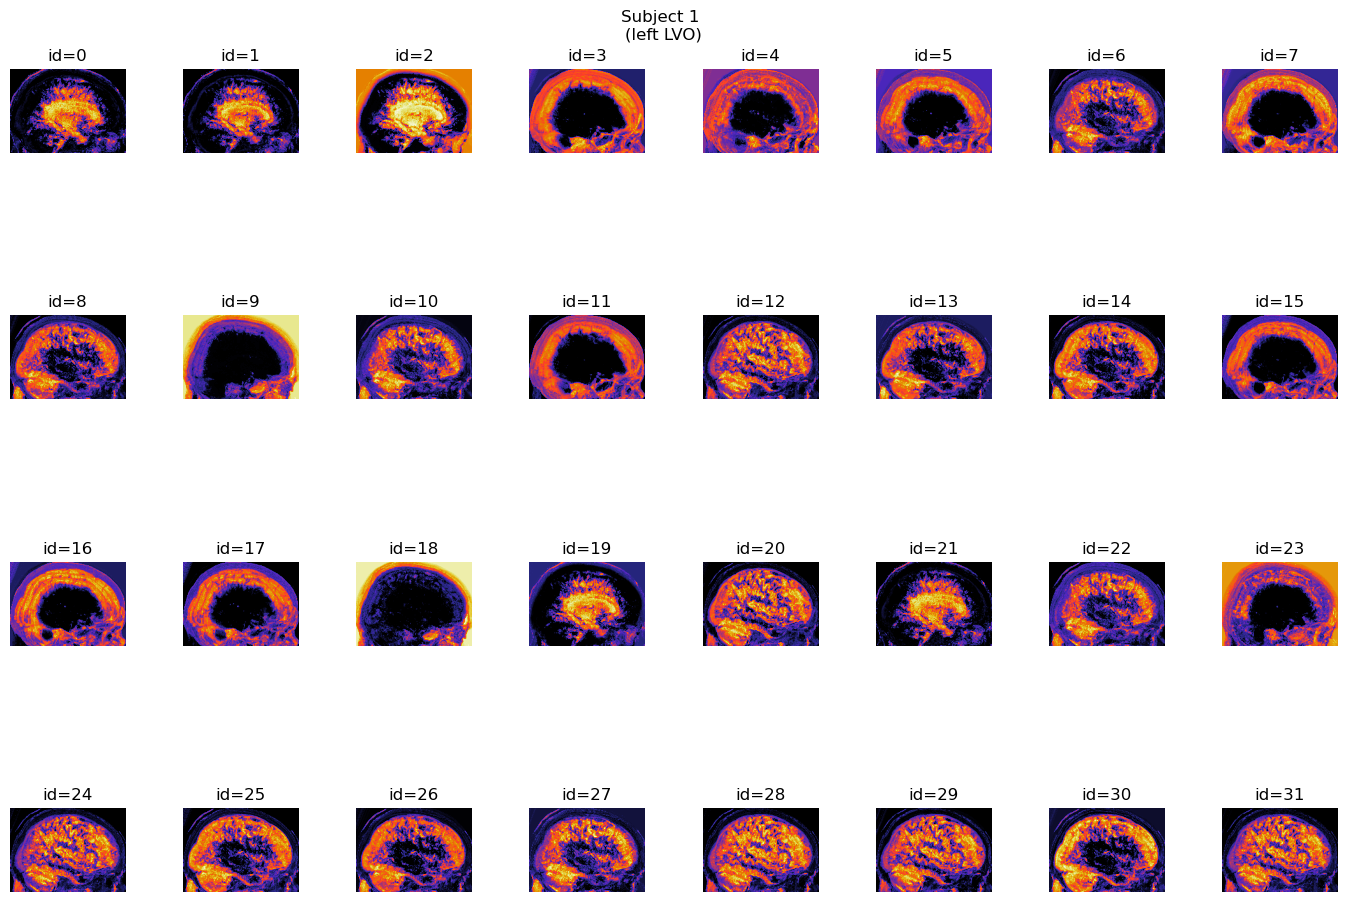


 
 Prediction :  LVO-affected hemisphere (0: right; 1: left)    0.0492


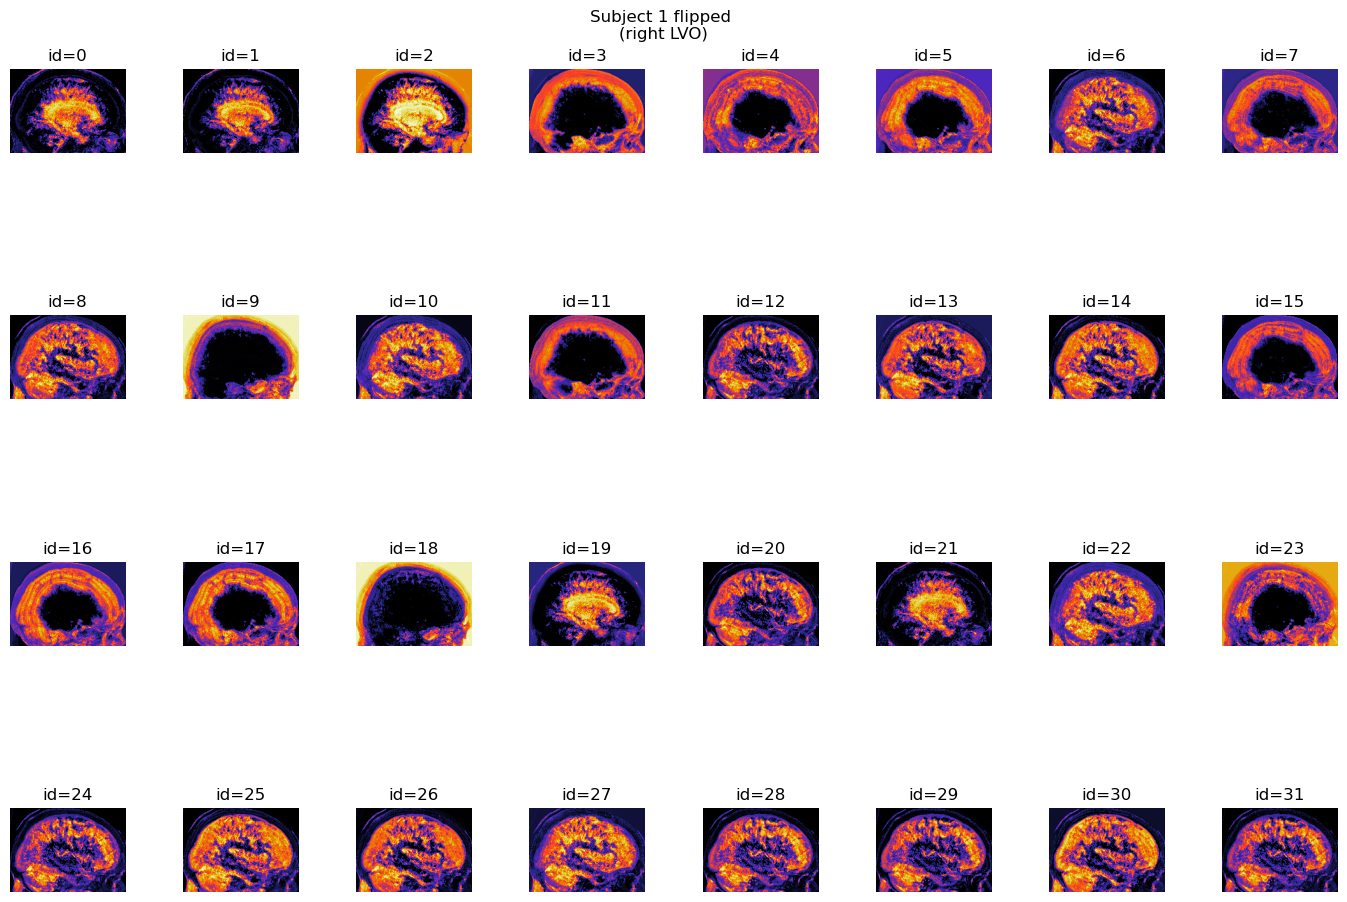


 
 Prediction :  LVO-affected hemisphere (0: right; 1: left)    0.0929


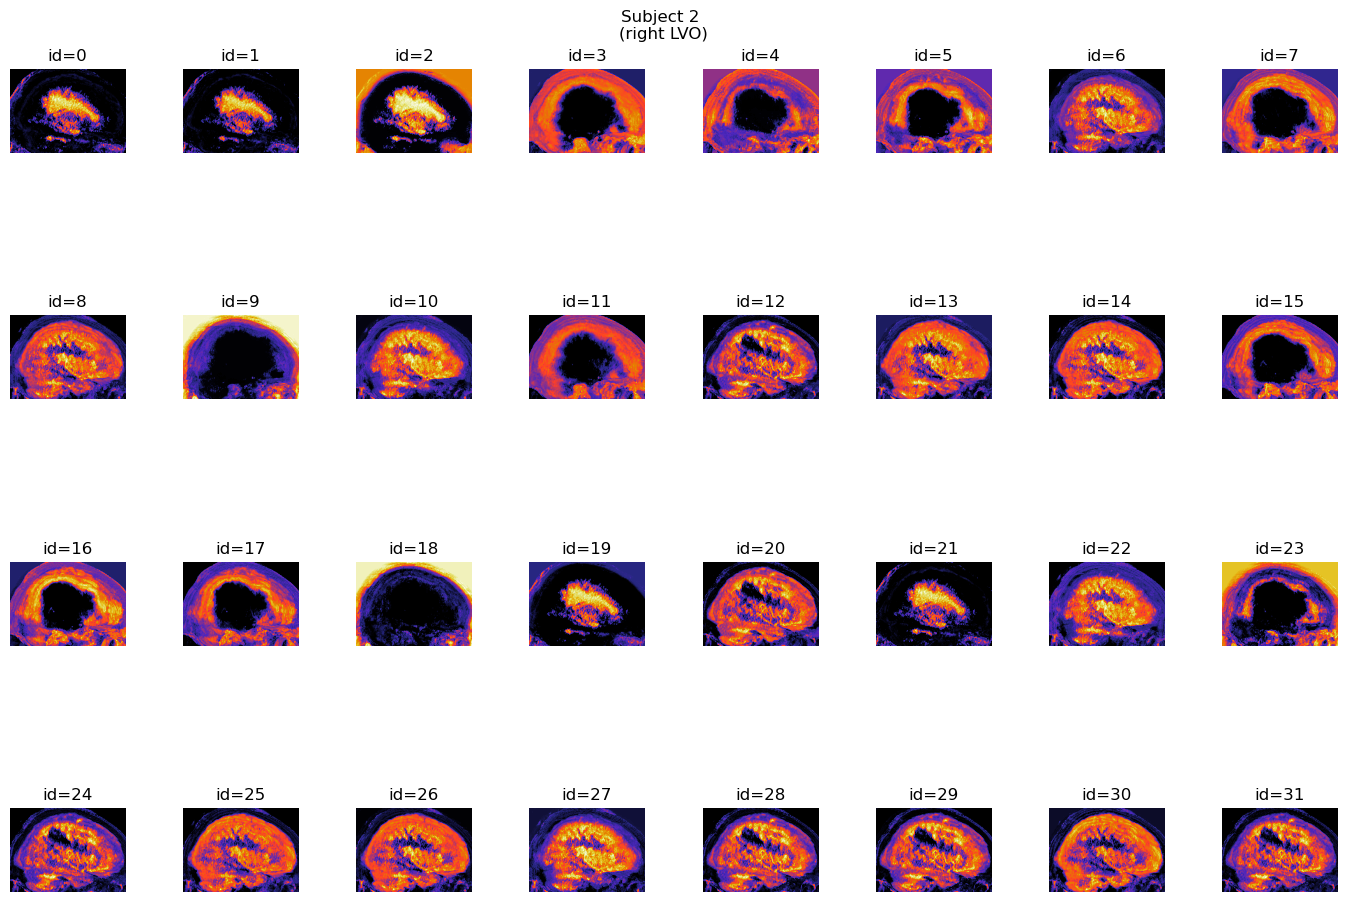


 
 Prediction :  LVO-affected hemisphere (0: right; 1: left)    0.2493


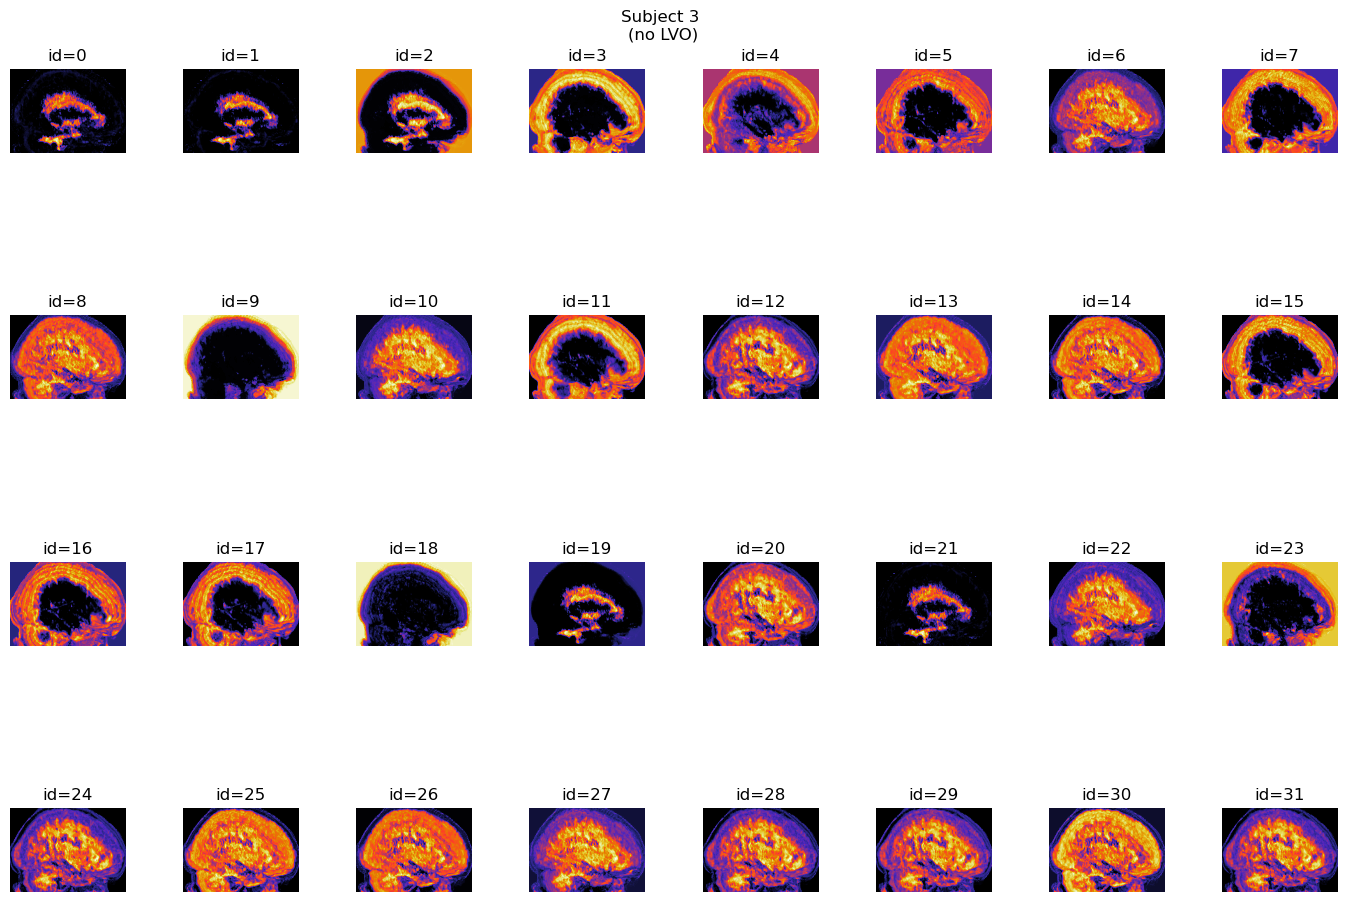

In [17]:
subj1 = np.load('images/subject1.npy')
subj1_flipped = np.flip(np.copy(subj1), axis=2)
subj2 = np.load('images/subject2.npy')
subj3 = np.load('images/subject3.npy')
prediction_and_plot_feature_maps(subj1,model_loaded,'LVO-affected hemisphere (0: right; 1: left)','Subject 1 \n(left LVO)')
prediction_and_plot_feature_maps(subj1_flipped,model_loaded,'LVO-affected hemisphere (0: right; 1: left)','Subject 1 flipped \n(right LVO)')
prediction_and_plot_feature_maps(subj2,model_loaded,'LVO-affected hemisphere (0: right; 1: left)','Subject 2 \n(right LVO)')
prediction_and_plot_feature_maps(subj3,model_loaded,'LVO-affected hemisphere (0: right; 1: left)','Subject 3 \n(no LVO)')

## LVO detection

In [18]:
model = L3P_isotropic_with_symmetry_2D_CNN_axial()
model_ckpt = 'models/pretrained weights/LVO-presence-L3P_isotropic_with_symmetry_2D_CNN.ckpt'
model_loaded = classificationModel.load_from_checkpoint(checkpoint_path=model_ckpt, number_classes=1, model=model, map_location='cuda:'+str(gpusToUse[0])+'')


 
 Prediction :  LVO detection (0: absence; 1: presence)    0.9993


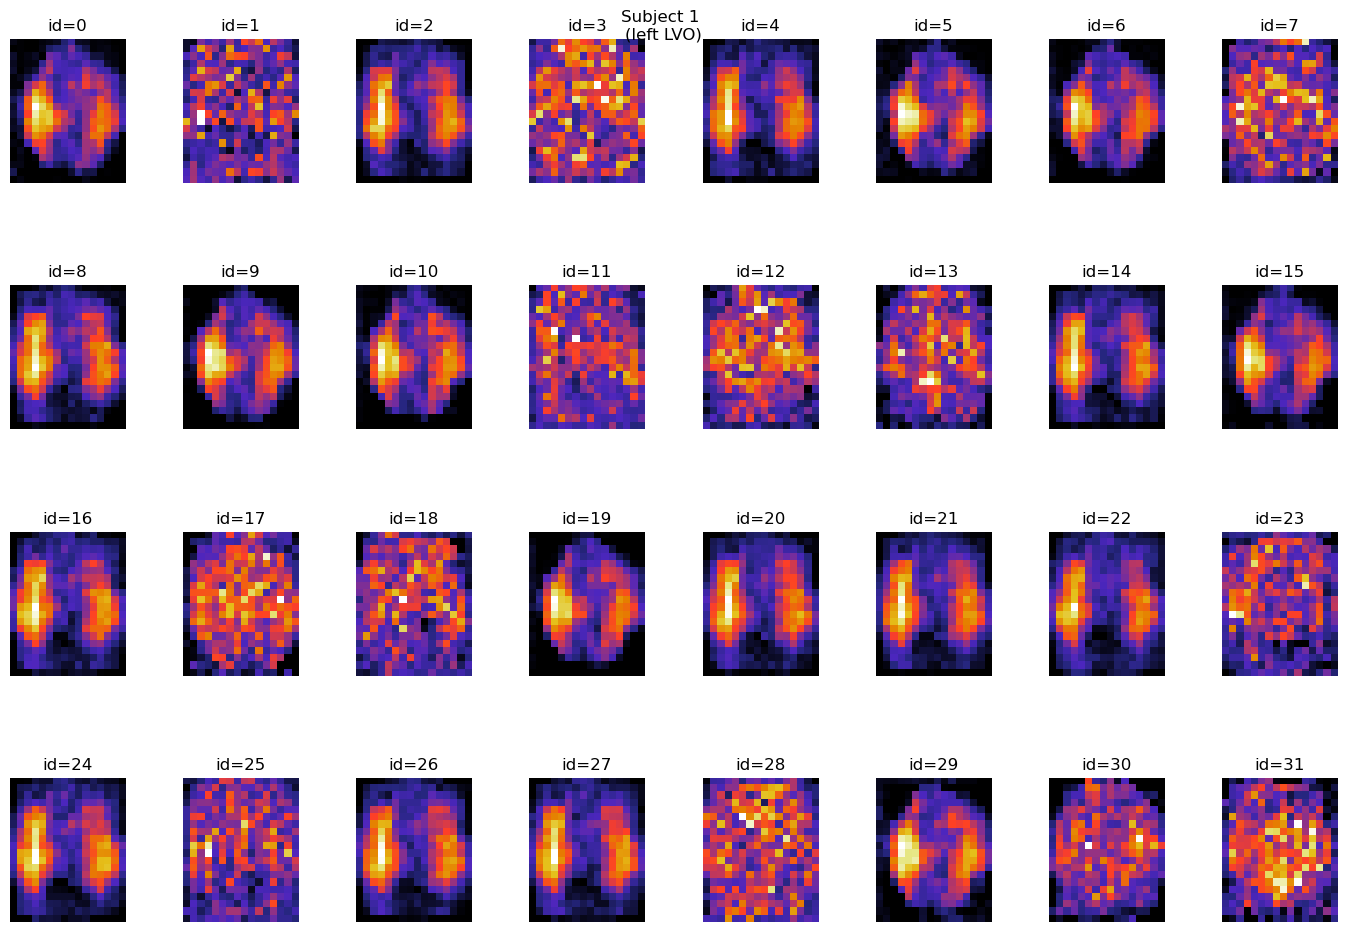


 
 Prediction :  LVO detection (0: absence; 1: presence)    0.9366


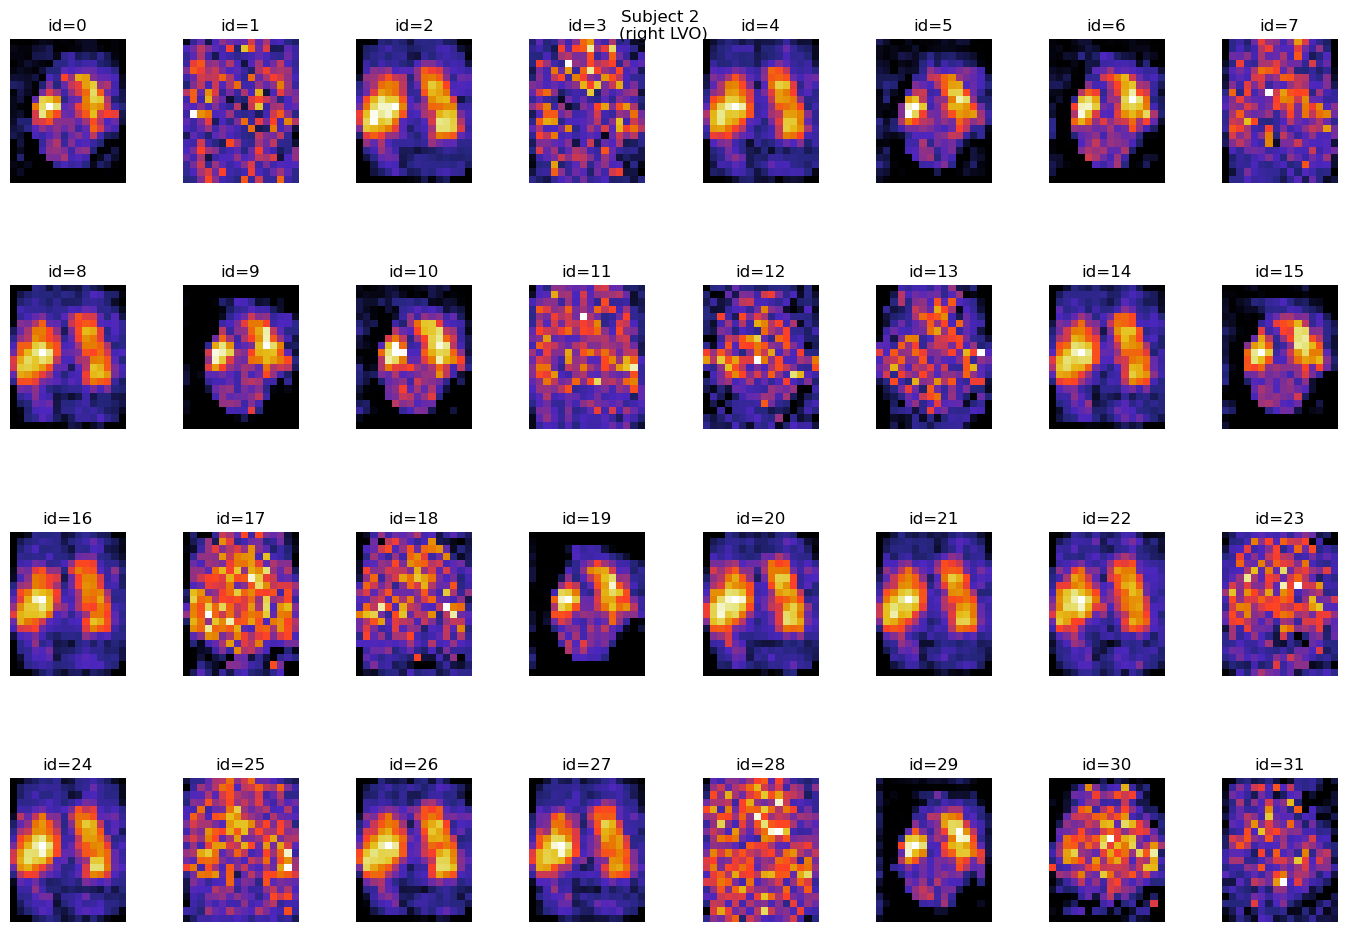


 
 Prediction :  LVO detection (0: absence; 1: presence)    0.0539


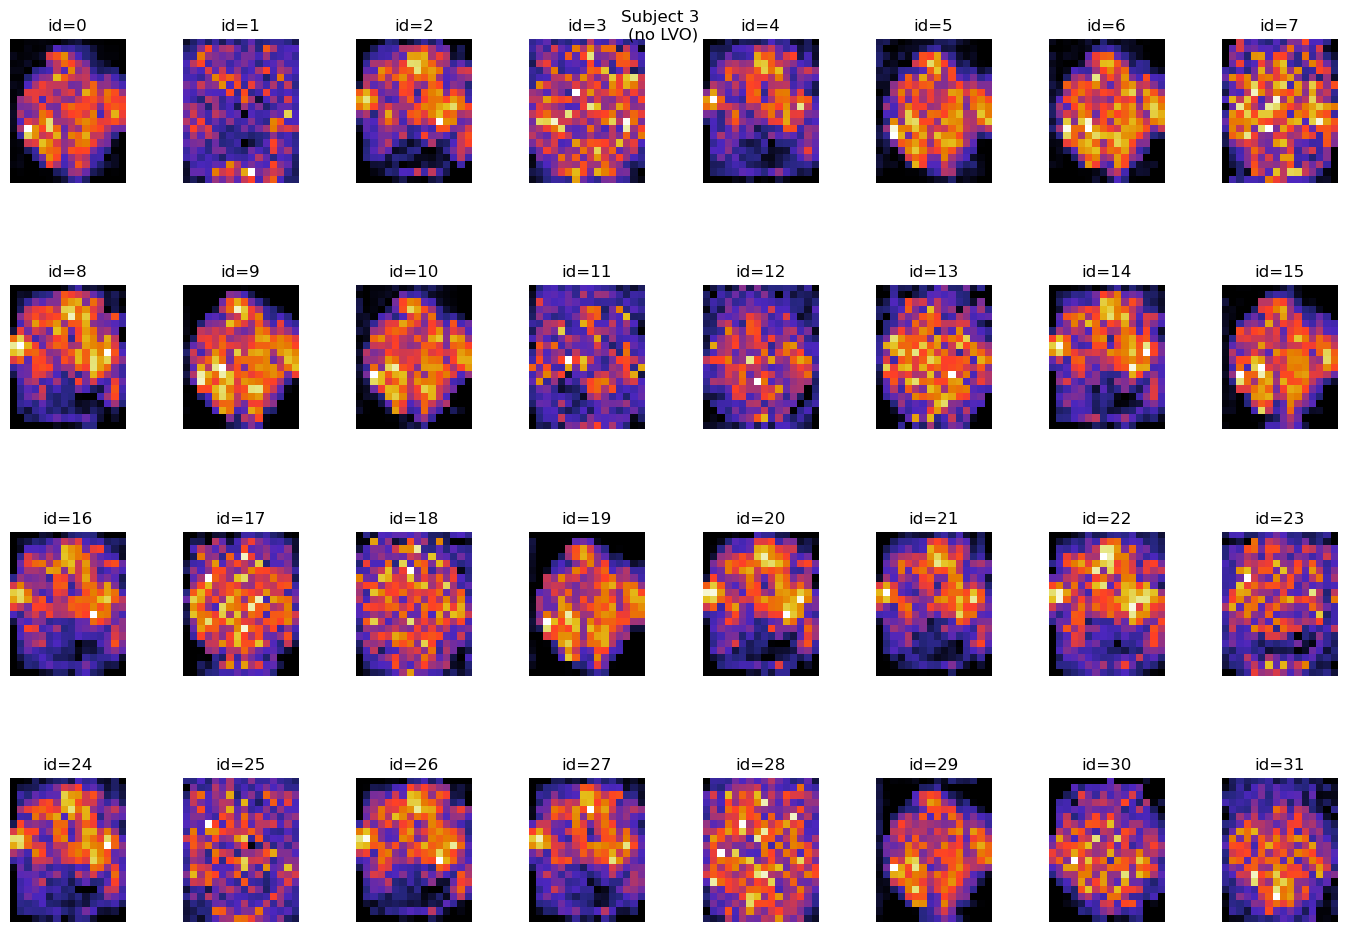

In [19]:
prediction_and_plot_feature_maps(subj1,model_loaded,'LVO detection (0: absence; 1: presence)','Subject 1 \n(left LVO)')
prediction_and_plot_feature_maps(subj2,model_loaded,'LVO detection (0: absence; 1: presence)','Subject 2 \n(right LVO)')
prediction_and_plot_feature_maps(subj3,model_loaded,'LVO detection (0: absence; 1: presence)','Subject 3 \n(no LVO)')